- Load an image and polynomials.
- Detect the center of parallel lines.

In [2]:
%%javascript 
// To get notebook's full path
var kernel = Jupyter.notebook.kernel; 
var command = ["notebookPath = ",
               "'", window.document.body.dataset.notebookPath, "'" ].join('')
//alert(command)
kernel.execute(command)
var command = ["notebookName = ",
               "'", window.document.body.dataset.notebookName, "'" ].join('')
//alert(command)
kernel.execute(command)

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import os, sys

dir_path = os.path.dirname(os.path.abspath(notebookName))

# Path to Computer root directory
ROOT_DIR = os.path.realpath(os.path.join(dir_path, '..'))

sys.path.append(ROOT_DIR)
from libraries.helpers import configuration, prepare_initial_transformation, preprocess_line_finding_dist
from libraries.line_helpers import annotate_with_lines

import pdb
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display
import math

config = configuration()

TARGET_WIDTH = config['target_width']
TARGET_HEIGHT = config['target_height']
TARGET_CROP = config['target_crop']
STEER_MIN = config['steer_min']
STEER_MAX = config['steer_max']
CHANNELS = config['channels']
NORMALIZE = config['normalize']

# Set this to images directory
img_dir = "/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test"
# Set this to a .txt file that contains filenames.
# img_paths = list(map(lambda x: os.path.join(img_dir, 'recorded', x), load_from(os.path.join(img_dir, 'poly1.txt'))))
img_paths = glob.glob("/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test/recorded/*.jpg")

mtx, dist, M, Minv = prepare_initial_transformation(
    os.path.join(ROOT_DIR, 'calibrations', 'cal-elp.p'), TARGET_HEIGHT, TARGET_WIDTH)

Using TensorFlow backend.


In [14]:
def draw_poly(background, poly_coeffs, orient, degree=2, keep_background=True, color=(0, 255, 0), thickness=3):
    """ Draw (2-degree) polynomial line on an image.
    Args:
      - orient: 'v' or 'h'.
    """
    # Create an image to draw the lines on
    if keep_background:
        canvas = np.array(background, dtype=np.uint8)
    else:
        canvas = np.zeros_like(background).astype(np.uint8)
        
    # If grey image, convert to three channels
    if len(canvas.shape) == 2 or canvas.shape[2] == 1:
        canvas = np.stack((canvas, canvas, canvas), axis=2)
        canvas = (canvas * 255.0).astype(np.uint8)
        
    height = background.shape[0]
    width = background.shape[1]
    xlist = []
    ylist = []
    if orient == 'v':
        for yh in range(height):
            y = height-yh
            x = 0
            for i in range(degree+1):
                x += poly_coeffs[i]*y**(degree-i)
            xlist.append(x)
            ylist.append(yh)
    elif orient == 'h':
        for xw in range(width):
            y = 0
            for i in range(degree+1):
                y += poly_coeffs[i]*xw**(degree-i)
            x = width-xw
            ylist.append(y)
            xlist.append(x)
    else:
        raise ValueError("orient must be either 'v' or 'h'.")
    xlist = np.array(xlist, np.int32)
    ylist = np.array(ylist, np.int32)
    pts = np.array([np.transpose(np.vstack([xlist, ylist]))], np.int32)
    cv2.polylines(canvas, np.int_([pts]), False, color, thickness=thickness)
    return canvas

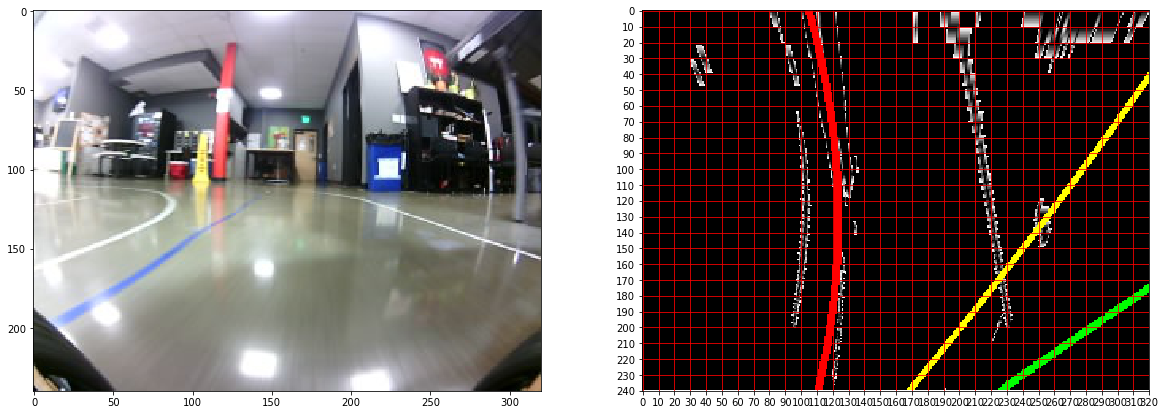

In [19]:
def find_poly(change=None):
    line1_coef1 = line1_coef1_i.value * 1.0e-07
    line1_coef2 = line1_coef2_i.value * 1.0e-04
    line1_coef3 = line1_coef3_i.value

    line2_coef1 = line2_coef1_i.value * 1.0e-07
    line2_coef2 = line2_coef2_i.value * 1.0e-04
    line2_coef3 = line2_coef3_i.value

    img_path = '/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test/recorded/2017-06-12_05-10-44.410157.jpg'

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)

    line1 = [line1_coef1, line1_coef2, line1_coef3]
    img = preprocess_line_finding_dist(img, M)
    img = draw_poly(img, line1, 'v', color=(255, 0, 0))

    line2 = [line2_coef1, line2_coef2, line2_coef3]
    img = draw_poly(img, line2, 'v', color=(0, 255, 0))

#     wp = [wp_coef1, wp_coef2, wp_coef3]
    wp = [(line1_coef1+line2_coef1)/2,
          (line1_coef2+line2_coef2)/2,
          (line1_coef3+line2_coef3)/2,]
    img = draw_poly(img, wp, 'v', color=(255, 255, 0))

    ax2.imshow(img)
#     ax2.grid = True
    ax2.grid(True, linestyle='-', color='r', zorder=1)
    plt.xticks(np.arange(0, img.shape[1]+1, 10))
    plt.yticks(np.arange(0, img.shape[0]+1, 10))

    clear_output(True)
#     print("line1:", line1)
#     print("line2:", line2)
#     print("waypoints:", wp)


line1_coef1_i = IntSlider(description='line1 coef1', min=-100000, max=100000, step=1, value=-10809)
line1_coef2_i = IntSlider(description='line1 coef2', min=-100000, max=100000, step=1, value=2355)
line1_coef3_i = FloatSlider(description='line1 coef3', min=0, max=329, step=1, value=1.11098465e+02)

line2_coef1_i = IntSlider(description='line2 coef1', min=-500000, max=500000, step=1, value=-169404)
line2_coef2_i = IntSlider(description='line2 coef2', min=-100000, max=100000, step=1, value=16765)
line2_coef3_i = FloatSlider(description='line2 coef3', min=0, max=329, step=1, value=5.18607136e+01)

line1_coef1_i.observe(find_poly, 'value')
line1_coef2_i.observe(find_poly, 'value')
line1_coef3_i.observe(find_poly, 'value')
line2_coef1_i.observe(find_poly, 'value')
line2_coef2_i.observe(find_poly, 'value')
line2_coef3_i.observe(find_poly, 'value')


# -1.97936102e-03   3.02882505e-01   9.59075945e+01
# -1.97936102e-03   3.02882505e-01   9.59075945e+01
# -1.97936102e-03   3.02882505e-01   9.59075945e+01
# -1.97936102e-03   6.47210786e-01   5.45882008e+01

# -1.40038985e-04  -1.57436939e-01   7.73684967e+01
# 8.04784042e-04  -9.54703892e-01   2.29195678e+02

# -1.08086259e-03   2.35503947e-01   1.11098465e+02
# -1.69404818e-02   9.16531118e+00  -1.14633352e+03

# -1.69404818e-02   1.67659720e+00   5.18607136e+01


display(line1_coef1_i, line1_coef2_i, line1_coef3_i,
        line2_coef1_i, line2_coef2_i, line2_coef3_i)
find_poly()

In [86]:
1.08086259e-03*1.0e+07

10808.6259

In [82]:
from sympy.abc import x, y
import sympy
a = -1.40038985e-04
b = -1.57436939e-01
c = 7.73684967e+01

d = 8.04784042e-04
e = -9.54703892e-01
f = 2.29195678e+02

# x = a*y**2+b*y+c
# y = d*x**2+e*x+f

sympy.solve([x = a*y**2+b*y+c, y = d*x**2+e*x+f])

SyntaxError: invalid syntax (<ipython-input-82-7bf4df4082ac>, line 14)